In [18]:
using Distributions
using LinearAlgebra
using Plots
using Test
using Sobol
using Optim
using Profile
using PProf
using Random
using ProfileView

In [2]:
include("../rollout.jl")
include("../testfns.jl")

TestGramacyLee (generic function with 1 method)

### Psuedo-code for Rollout Bayesian Optimization
1. Generate low-discrepancy sequence for Quasi-Monte Carlo
2. Gather initial samples/experimental data
3. Construct the ground truth surrogate model
4. Setup hyperparameters for stochastic gradient descent
5. While budget has not been exhausted
<ol>
    <li>
        Construct a batch of samples for stochastic gradient descent. For each sample
        <ol>
            <li>Create a copy of the ground truth surrogate at the sample location and the pairwise perturbed surrogate.</li>
            <li style="color: #f66">Initialize our trajectory struct with the fantasized surrogate and fantisized perturbed surrogate and fantasy start location.</li>
            <li>Perform rollout on the trajectory for $r$ steps $M_0$ times for Quasi-Monte Carlo integration.</li>
            <li>Update values for $\alpha$ and $\nabla\alpha$</li>
        </ol>
    </li>
    <li>Once SGD has converged, update sample location using update rule</li>
    <li>Save location and value at location for each sample in batch.</li>
    <li>Select the best sample from the batch and sample original process at new sample location.</li>
    <li>Update surrogate model with value found at new sample location.</li>
    <li>Repeat until budget is exhausted.</li>
</ol>

### Issues
- Use control variates to see how they affect the rollout acquisition functions

#### Probability of Improvement
The probability of improvement (POI) is defined as follows:

$$
POI(x) = \Phi\left( \frac{\mu(x) - f^+ - \xi}{\sigma(x)} \right)
$$

where $f^+$ denotes the best value (maximum) known, $\mu(x)$ is the predictive mean at x, $\sigma(x)$ is the predictive variance, $\xi$ is our exploration parameter, and $\Phi$ is the standard normal cumulative distribution function.
<hr>

#### Expected Improvement
The expected improvement (EI) is defined as follows:

$$
EI(x) = (\mu(x) - f^+ - \xi)\Phi\left( \frac{\mu(x) - f^+ - \xi}{\sigma(x)} \right) +
        \sigma(x)\phi\left(\frac{\mu(x) - f^+ - \xi}{\sigma(x)}\right)
$$

where $\phi$ is the standard normal probability density function.
<hr>

In [3]:
function ei(μ, σ, fbest)
    z = (fbest - μ) / σ
    Φz = Distributions.normcdf(z)
    ϕz = Distributions.normpdf(z)
    return σ*(z*Φz + ϕz)
end

function poi(μ, σ, fbest)
    z = (fbest - μ) / σ
    Φz = Distributions.normcdf(z)
    return Φz
end

poi (generic function with 1 method)

In [4]:
# Global parameters
MAX_SGD_ITERS = 100
BATCH_SIZE = 10
HORIZON = 0
MC_SAMPLES = 100
BUDGET = 1;

### 1. Generate low-discrepancy sequence for Quasi-Monte Carlo

In [5]:
# Setup toy problem
testfn = TestFunction(
    1, [0. 1.], [.5],
    x -> 0. + 1e-6*randn(),
    ∇x -> [0. + 1e-6*randn()]
)
lbs, ubs = testfn.bounds[:,1], testfn.bounds[:,2]

# Setup low discrepancy random number stream
lds_rns = gen_low_discrepancy_sequence(MC_SAMPLES, testfn.dim, HORIZON+1);
rns = randn(MC_SAMPLES, testfn.dim+1, HORIZON+1);

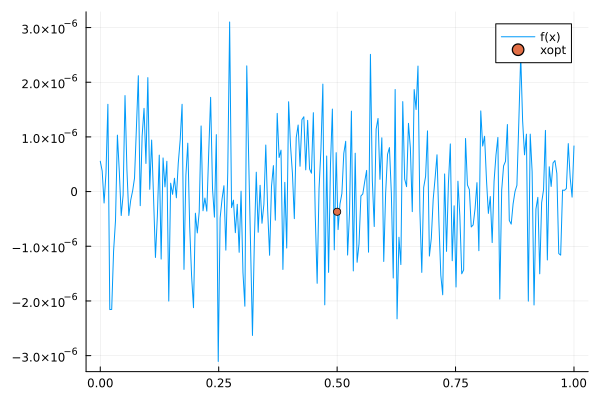

In [6]:
tplot(testfn)

### 2. Gather initial samples/experimental data

In [7]:
# Gather initial samples/experimental data
N, θ = 1, [.25]
X = [.15, .85]
X = reshape(X, 1, length(X))
# ψ = kernel_matern52(θ);
ψ = kernel_scale(kernel_matern52, [1., θ...]);

### 3. Construct the ground truth surrogate model

In [8]:
sur = fit_surrogate(ψ, X, testfn.f);
# θ, sur = optimize_hypers(ψ.θ, kernel_matern52, sur.X, testfn.f);

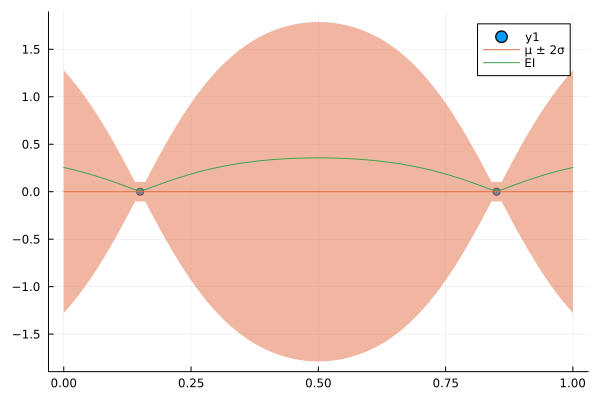

In [9]:
domain = filter(x -> !(x in X), lbs[1]:.01:ubs[1])
scatter(sur.X', sur.y)
plot!(domain, [sur([x]).μ for x in domain],
    ribbons=2*[sur([x]).σ for x in domain], label="μ ± 2σ")
plot!(domain, [sur([x]).EI for x in domain], label="EI")

### 4. Setup hyperparameters for stochastic gradient descent

In [10]:
λ = 1e-1; # Vanilla stochastic gradient descent

### 5. While budget has not been exhausted
Each location in our minibatch is going to be our $x^0$ that serves as our deterministic start location. Then, we perform rollout from that point forward, computing several sample trajectories to then be averaged.

In [19]:
eis, ∇eis = [], []
T = nothing
# for random_number_stream in [lds_rns, rns]
for random_number_stream in [lds_rns]
    rollout_ei = [0 0] # Sample mean and variance tuples
    ∇rollout_ei = [0 0] # Sample mean and variance tuples
    
    println("Total '|'s => $(length(domain))")
    # for x0 in [.25, .33, .67, .75]
    for x0 in domain
        print("|$x0")
        # Grab each input location and convert to a column vector
        x0 = [x0]

        αxs, ∇αxs = [], []
        # Monte-carlo integrate trajectory for x0
        @profview begin
        for sample in 1:MC_SAMPLES
            # Make a copy of our surrogate to pass to the trajectory struct
            # for fantasized computations
            fsur = Base.deepcopy(sur)
            fantasy_ndx = size(fsur.X, 2) + 1

            # Rollout trajectory
            T = Trajectory(fsur, x0, fantasy_ndx; h=HORIZON, fopt=minimum(sur.y) + sur.ymean)
            rollout!(T, lbs, ubs; rnstream=random_number_stream[sample,:,:])

            # Evaluate rolled out trajectory
            push!(αxs, α(T))
            push!(∇αxs, first(∇α(T)))
        end # endfor sample
        end

        # Average trajectories
        μx = sum(αxs) / length(αxs)
        ∇μx = sum(∇αxs) / length(αxs)
        σx = sum((αxs .- μx) .^ 2) / (MC_SAMPLES-1)
        ∇σx = sum((∇αxs .- ∇μx) .^ 2) / (MC_SAMPLES-1)

        # Update history
        sx = sur(x0)
        μx += ei(sx.μ, sx.σ, minimum(sur.y)) + poi(sx.μ, sx.σ, minimum(sur.y))
        rollout_ei = vcat(rollout_ei, [μx σx])
        ∇rollout_ei = vcat(∇rollout_ei, [∇μx ∇σx])
    end # endfor x0
    rollout_ei = rollout_ei[2:end, :]
    ∇rollout_ei = ∇rollout_ei[2:end, :];
    
    push!(eis, rollout_ei)
    push!(∇eis, ∇rollout_ei)
end

Total '|'s => 99
|0.0|0.01|0.02|0.03|0.04|0.05|0.06|0.07|0.08|0.09|0.1|0.11|0.12|0.13|0.14|0.16|0.17|0.18|0.19|0.2|0.21|0.22|0.23|0.24|0.25|0.26|0.27|0.28|0.29|0.3|0.31|0.32|0.33|0.34|0.35|0.36|0.37|0.38|0.39|0.4|0.41|0.42|0.43|0.44|0.45|0.46|0.47|0.48|0.49|0.5|0.51|0.52|0.53|0.54|0.55|0.56|0.57|0.58|0.59|0.6|0.61|0.62|0.63|0.64|0.65|0.66|0.67|0.68|0.69|0.7|0.71|0.72|0.73|0.74|0.75|0.76|0.77|0.78|0.79|0.8|0.81|0.82|0.83|0.84|0.86|0.87|0.88|0.89|0.9|0.91|0.92|0.93|0.94|0.95|0.96|0.97|0.98|0.99|1.0

In [22]:
ProfileView.closeall()